# Lab 01 - Regresión Logística
Este cuadernillo fue diseñado por IBM y utilizado para práctica en el curso de Modelos de Aprendizaje Supervisado del IBM en Coursera. El presente es una traducción que realicé al documento.

## Introduction
Estaremos utilizando la base de datos [Reconocimiento de las Actividades Humanas con Smartphones](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones) que se construyó a partir de las grabaciones de los participantes en el estudio que llevaban un smartphone con un sensor inercial incorporado mientras realizaban actividades de la vida diaria (AVD). El objetivo es clasificar las actividades realizadas por los participantes en una de las seis categorías siguientes: caminar, subir escaleras, bajar escaleras, sentarse, estar de pie y tumbarse.

Se proporciona la siguiente información para cada registro del conjunto de datos:

- Aceleración triaxial del acelerómetro (aceleración total) y aceleración corporal estimada.
- Velocidad angular triaxial del giroscopio
- Un vector de 561 características con variables de dominio temporal y frecuencial
- La etiqueta de actividad

Encontrará más información sobre las características en el sitio web enlazado más arriba.




In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

Matplotlib is building the font cache; this may take a moment.


### Question 1

Importa la data y realiza lo siguiente:
- Examine los tipos de datos presentes, note que hay muchas columnas y puede ser conveniente utiilizar la función `.value_counts()`.
- Determine si es necesario escalar los valores en coma tipo flotante.
- Determine el desglose de cada actividad.
- Cambie el tipo de datos de la columna 'Activity' a entero.

In [3]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

Los datos de cada columna son decimal exceptuando la columna 'Activity'

In [4]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

Examine la distribución de las actividades, noté que están relativamente balanceadas. 

In [6]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Los modelos de clasificación de la librería Sckit Learn no aceptarán una matriz dispersa para la columna de predicción.
Por lo tanto, puede usar `LabelEncoder` para convertir las etiquetas de actividades a enetero, o si usa `DictVectorizer`, la matriz resultante debe ser convertida a un arreglo no dispersa.

Usa `LabelEncoder` para aplicar `fit_transform` a la columna 'Activity' y observa 5 valores aleatorios."

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

1954    0
1047    1
9722    5
473     4
9273    0
Name: Activity, dtype: int64

### Question 2

- Calcular la correlación entre las variables dependientes
- Crear un histograma de los valores de corrrelación
- Indentificar aquellos que estan más relacionados (tanto de manera positiva como negativa)

In [9]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

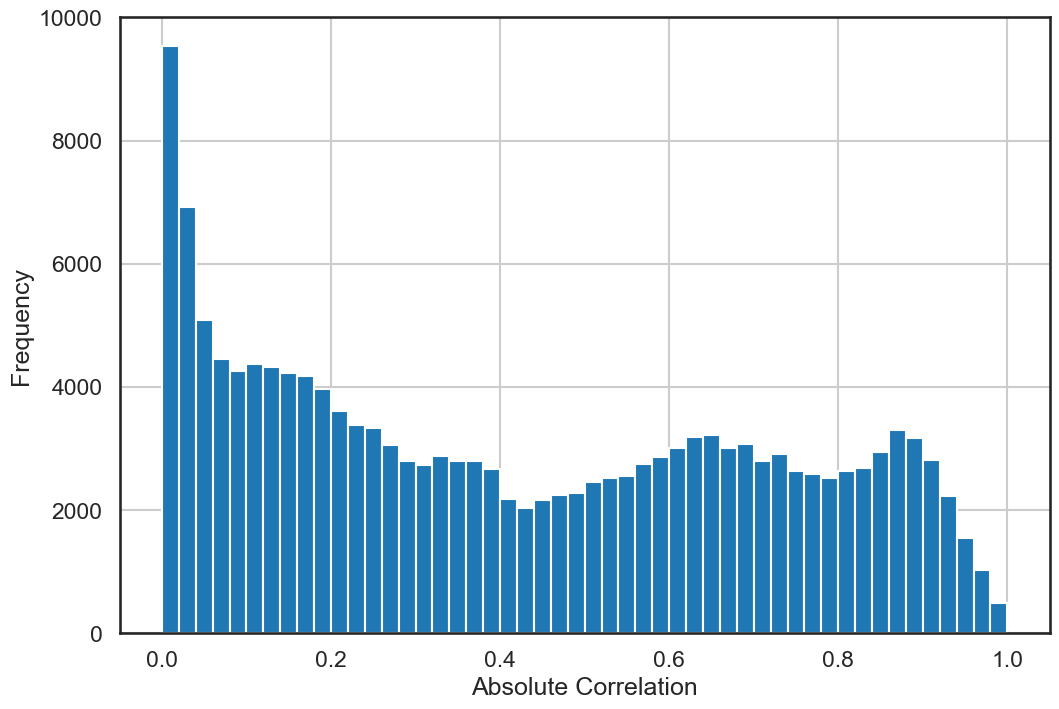

In [11]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


### Question 3
- Dividir los datos entre entrenamiento y prueba. Esto puede realizarse usando cualquier mmétodo, pero considere usar la función `StratifiedShuff` de Sckit Learn para mantener la misma proporción de clases predictoras.
- Independientemente del método utilizado para dividir los datos, compare la proporción de clases tanto en la división de entrenamiento como en la de prueba.

In [13]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

### Question 4
- Ajuste un modelo de regresión logística sin ningún metodo de estandarización y utilizando todas las cracterísticas. Asegúrese de leer la documentación sobre el ajuste de un modelo multiclase para entender la salida de coeficientes. Guarde el modelo.
- Utilizar la validación cruzada para determinar los hiperparámetros y ajustar los modelos utilizando la regularización L1 y L2. Almacenar también cada uno de estos modelos. Tenga en cuenta las limitaciones de los modelos multiclase, los solucionadores y las regularizaciones. Los modelos regularizados, en particular el modelo L1, probablemente tardarán en ajustarse.

In [16]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [ ]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

### Question 5
- Compare las magnitudes de los coeficientes de cada uno de los modelos. Si se ha utilizado el ajuste uno contra uno, cada conjunto de coeficientes puede representarse por separado.

In [ ]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

Prepare seis gráficos distintos para cada uno de los coeficientes multiclase.

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

### Question 6
- Predecir y almacenar la clase para cada modelo.
- Almacenar la probabilidad de la clase predicha para cada modelo.

In [ ]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

In [ ]:
y_prob.head()
### END SOLUTION

### Question 7
Para cada modelo, calcule las siguientes métricas de error:

- Accuracy
- Precision
- Recall
- F-score
- Matriz de confusión

Decida cómo combinar las métricas multiclase en un único valor para cada modelo.

In [ ]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [ ]:
metrics
### END SOLUTION

### Question 8
- Visualizar o trazar la matriz de confusión de cada modelo.

In [ ]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation

Traduccido por: Camilo Rafael Pérez Chaves